In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!rm -rf sample_data
!pip install tensorflow==1.15

     |████████████████████████████████| 412.3MB 44kB/s 
     |████████████████████████████████| 51kB 5.6MB/s 
     |████████████████████████████████| 512kB 38.9MB/s 
     |████████████████████████████████| 3.8MB 38.1MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=cdbecb8cbcccf5b2ddda422a4b5de9db92857017556e2fe3c2192fb054d97da4
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninsta

In [3]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

In [4]:
def unpickle(file, encoding='bytes'):
    with open(file, 'rb') as f:
        di = pickle.load(f, encoding=encoding)
    return di

In [5]:
PATH = "/content/drive/My Drive/Colab Notebooks/Image Classification NODE/CIFAR10_VGG"

In [6]:
batches_meta = unpickle(f"{PATH}/cifar-10-batches-py/batches.meta", encoding='utf-8')
label_names = batches_meta['label_names']

In [10]:
batch_labels = []
batch_images = []

for n in range(1, 6):
    batch_dict = unpickle(f"{PATH}/cifar-10-batches-py/data_batch_{n}")
    batch_labels.append(batch_dict[b'labels'])
    data = batch_dict[b'data'].reshape((10000,3,32,32))
    data = np.moveaxis(data, 1, -1)
    batch_images.append(data)

labels = np.concatenate(batch_labels, axis=0)
images = np.concatenate(batch_images, axis=0)

In [11]:
test_dict = unpickle(f"{PATH}/cifar-10-batches-py/test_batch")
test_labels = np.array(test_dict[b'labels'])
test_images = test_dict[b'data'].reshape((10000,3,32,32))
test_images = np.moveaxis(test_images, 1, -1)

In [13]:
showSampleImages = False

if showSampleImages:
    fig = plt.figure(figsize=(14,10))
    for n in range(1, 29):
        fig.add_subplot(4, 7, n)
        img = images[n]
        plt.imshow(img)
        plt.title(label_names[labels[n]], color = "white")
        plt.axis('off')

In [14]:
class ODEBlock(tf.keras.layers.Layer):

    def __init__(self, filters, kernel_size, **kwargs):
        self.filters = filters
        self.kernel_size = kernel_size
        super(ODEBlock, self).__init__(**kwargs)
        
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'filters': self.filters,
            'kernel_size': self.kernel_size,
        })
        return config

    def build(self, input_shape):
        self.conv2d_w1 = self.add_weight("conv2d_w1", self.kernel_size + (self.filters + 1, self.filters), initializer='glorot_uniform')
        self.conv2d_w2 = self.add_weight("conv2d_w2", self.kernel_size + (self.filters + 1, self.filters), initializer='glorot_uniform')
        self.conv2d_b1 = self.add_weight("conv2d_b1", (self.filters,), initializer='zero')
        self.conv2d_b2 = self.add_weight("conv2d_b2", (self.filters,), initializer='zero')
        super(ODEBlock, self).build(input_shape)

    def call(self, x):
        t = K.constant([0, 1], dtype="float32")
        return tf.contrib.integrate.odeint(self.ode_func, x, t, rtol=1e-3, atol=1e-3)[1]

    def compute_output_shape(self, input_shape):
        return input_shape

    def ode_func(self, x, t):
        y = self.concat_t(x, t)
        y = K.conv2d(y, self.conv2d_w1, padding="same")
        y = K.bias_add(y, self.conv2d_b1)
        y = K.relu(y)

        y = self.concat_t(y, t)
        y = K.conv2d(y, self.conv2d_w2, padding="same")
        y = K.bias_add(y, self.conv2d_b2)
        y = K.relu(y)

        return y

    def concat_t(self, x, t):
        new_shape = tf.concat(
            [
                tf.shape(x)[:-1],
                tf.constant([1],dtype="int32",shape=(1,))
            ], axis=0)

        t = tf.ones(shape=new_shape) * tf.reshape(t, (1, 1, 1, 1))
        return tf.concat([x, t], axis=-1)

In [15]:
X_train = preprocess_input(images)
y_test = to_categorical(test_labels)

X_test = preprocess_input(test_images)
y_train = to_categorical(labels)

In [16]:
def dcodnn(input_shape, num_classes):
    model = Sequential()
    vgg_model = VGG16(weights = None, include_top = True, input_shape= input_shape, classes = num_classes)
    
    for layers in vgg_model.layers[:-4]:
        model.add(layers)

    model.add(ODEBlock(512, (3,3)))

    for layers in vgg_model.layers[-4:]:
        model.add(layers)
    return model
    
num_classes = 10
image_shape = (32, 32, 3)
model = dcodnn(image_shape, num_classes)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)         2

In [18]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['acc']
)

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    f'{PATH}/weights/model.h5', 
    monitor='acc', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

epochs = 30
batch_size = 256

history = model.fit(X_train, y_train,
                    epochs = epochs,
                    batch_size=batch_size, 
                    verbose = 1, 
                    validation_data=(X_test, y_test), 
                    callbacks=[checkpoint])

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
49920/50000 [============================>.] - ETA: 0s - loss: 2.2404 - acc: 0.1560
Epoch 00001: acc improved from -inf to 0.15606, saving model to /content/drive/My Drive/Colab Notebooks/Image Classification NODE/CIFAR10_VGG/weights/model.h5
50000/50000 [==============================] - 42s 843us/sample - loss: 2.2404 - acc: 0.1561 - val_loss: 2.2209 - val_acc: 0.1930
Epoch 2/30
49920/50000 [============================>.] - ETA: 0s - loss: 2.0140 - acc: 0.2647
Epoch 00002: acc improved from 0.15606 to 0.26474, saving model to /content/drive/My Drive/Colab Notebooks/Image Classification NODE/CIFAR10_VGG/weights/model.h5
50000/50000 [==============================] - 26s 523us/sample - loss: 2.0139 - acc: 0.2647 - val_loss: 1.9315 - val_acc: 0.2861
Epoch 3/30
49920/50000 [============================>.] - ETA: 0s - loss: 1.8455 - acc: 0.3279
Epoch 00003: acc improved from 0.26474 to 0.32782, saving model to /content/drive/My

In [21]:
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,acc,val_loss,val_acc
0,2.240412,0.15606,2.220895,0.1930
1,2.013866,0.26474,1.931528,0.2861
2,1.845435,0.32782,1.719241,0.3570
3,1.703583,0.38230,1.700530,0.3905
4,1.580987,0.43086,1.532956,0.4372


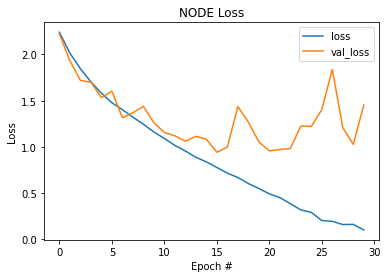

In [22]:
history_df[['loss', 'val_loss']].plot()
plt.title("NODE Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")

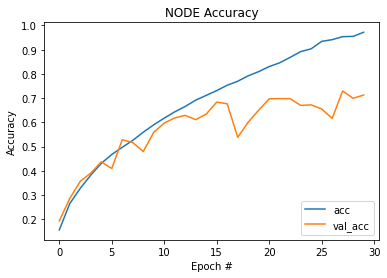

In [23]:
history_df[['acc', 'val_acc']].plot()
plt.title("NODE Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

In [24]:
model.load_weights(f'{PATH}/weights/model.h5')
train_loss, train_score = model.evaluate(X_train, y_train)
test_loss, test_score = model.evaluate(X_test, y_test)
print("Train Loss:", train_loss)
print("Test Loss:", test_loss)
print("Train F1 Score:", train_score)
print("Test F1 Score:", test_score)

10000/10000 [==============================] - 6s 644us/sample - loss: 1.4522 - acc: 0.7128
Train Loss: 0.11345851946786047
Test Loss: 1.4522267342567443
Train F1 Score: 0.96204
Test F1 Score: 0.7128


In [25]:
print("Training Accuracy:", round(100 * history.history['acc'][epochs - 1], 4))
print("Testing Accuracy:", round(100 * history.history['val_acc'][epochs - 1],4))

Training Accuracy: 97.212
Testing Accuracy: 71.28
